## Credits
I trained my LSTM using the very clear and concise example in this notebook(By Peter Nagy):

- https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

I learned how to use Word2Vec embeddings in my LSTM using the instructions in this notebook(user:lystdo):

- https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings

My First course on using word embeddings in python came from here:

- https://ai.intelligentonlinetools.com/ml/text-vectors-word-embeddings-word2vec/

A great trivial example of a LSTM implemetation, get the important stuff straight:

https://www.youtube.com/watch?v=iMIWee_PXl8

Adding an embedding layer to your LSTM in Keras

https://www.youtube.com/watch?v=8h8Z_pKyifM

## Reference material for Transformers and BERT

This is a great lecture by Pascal Pupoart as a first introduction to Transformers and Multi Headed Attention.

- https://youtu.be/OyFJWRnt_AY

This article by Jay Alammar is a great step by step documentation of the vector transformations that happen in a transformer.

- http://jalammar.github.io/illustrated-transformer/

This is a tutorial on using BERT as a classifier in the NLP context.

https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03




In [1]:
import numpy as np 
import pandas as pd 
pd.options.display.max_colwidth = 2000
from scipy import stats
import seaborn as sns
import math
from nltk.util import ngrams
from nltk.util import everygrams
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#---------------------------------------->Sentiment Analyser Libraries
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
#---------------------------------------->Sentiment Analyser Libraries

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv


Using TensorFlow backend.


In [2]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


     |████████████████████████████████| 90 kB 2.1 MB/s eta 0:00:011


'Tesla P100-PCIE-16GB'

### Prepare the data for training

In [3]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
# Keeping only the neccessary columns
data1 = df_train[['text','sentiment']]
data1['n_sentiment'] = data1.apply(lambda row: 'p' if row['sentiment']=='positive' else ('n' if row['sentiment']=='negative' else 'neu'), axis = 1)#--->Making the sentiment numeric
data1 = data1[['text','n_sentiment']]
data1.columns=['text','sentiment']
data2 = df_train[['selected_text','sentiment']]
data2.columns=['text','sentiment']
data2['n_sentiment'] = data2.apply(lambda row: 'vp' if row['sentiment']=='positive' else ('vn' if row['sentiment']=='negative' else 'neu'), axis = 1)#--->Making the sentiment numeric
data2 = data2[['text','n_sentiment']]
data2.columns=['text','sentiment']
data =  pd.concat([data1,data2])#-------------------------------------------------------------------------->Final Training Data
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',str(x))))#------------------------->Cleaning the tweets
print(len(data))
data['text_len'] = data.apply(lambda row:len(row['text']),axis=1)
data = data[data['text_len']!=0]
print(len(data))

#Tokenize the data
max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures,split=' ')
tokenizer = Tokenizer(split=' ')
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(data['text'].values)
print(len(X[2]))
X = pad_sequences(X)
print(len(X[2]))

#Split into training and test
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


54962
54867
5
34


In [4]:
#prepare the data for Bert

text_bert = list(data['text'])#-------------------->List of sentences
senti_bert = list(data['sentiment'])#-------------->List of Labels
senti_dict = {'neu':0,'p':1,'vp':2,'n':3,'vn':4}#-->Dictionary to convert labels to integers
f = lambda st:senti_dict[st]#---------------------->Function to assign label to the integer
senti_bert = [f(t) for t in senti_bert]#----------->Converting labels to integers
# add special tokens for BERT to work properly
text_bert = ["[CLS] " + t + " [SEP]" for t in text_bert]#-->Preparing sentences to be consumed by BERT


# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)#---->Creating a Tokenizer
tokenized_texts = [tokenizer.tokenize(sent) for sent in text_bert]#-------------------->Tokenizing the sentences
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


100%|██████████| 231508/231508 [00:00<00:00, 4374019.94B/s]


Tokenize the first sentence:
['[CLS]', 'i', '`', 'd', 'have', 'responded', 'if', 'i', 'were', 'going', '[SEP]']


In [5]:
# Set the maximum sequence length. 
MAX_LEN = 128#----------------------------->Is this the Max length of the sentences in words?
# Pad our input tokens
#Each word is converted into an integer and padding is applied
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")#------->Each word is converted into an integer and padding is applied
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
#This is just a repeat of the above code.
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [6]:
# Create attention masks
attention_masks = []#----------------------------------------->We need to understand what attention masks do.
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]#----------------------->Creates a list of True/False values True everywhere except for the padding
  attention_masks.append(seq_mask)

In [7]:
# Use train_test_split to split our data into train and validation sets for training
#This is self explanatory
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, senti_bert, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)#------------------------------------------------->What are torch tensors?
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32#---------------------------------------------------------------------------->Need to understand what batch size is.

# Create an iterator of our data with torch DataLoader#------------------------------------->What is an iterator here? 
train_data = TensorDataset(train_inputs, train_masks, train_labels)#------------------------>What does TensorDataset do?
train_sampler = RandomSampler(train_data)#-------------------------------------------------->What does RandomSampler do?
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)#---->What is a DataLoader?
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)#------------------------------------>What is a SequentialSampler?
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [8]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=5)#--->Declaring the Model
model.cuda()#------------------------------------------------------------------------------>What does .cuda() do?

100%|██████████| 407873900/407873900 [00:09<00:00, 41269305.58B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6887889551626123


Epoch:  25%|██▌       | 1/4 [13:00<39:02, 780.68s/it]

Validation Accuracy: 0.7822674418604652
Train loss: 0.4531410341754247


Epoch:  50%|█████     | 2/4 [26:01<26:01, 780.61s/it]

Validation Accuracy: 0.8053173449612402
Train loss: 0.3175219476628334


Epoch:  75%|███████▌  | 3/4 [39:00<13:00, 780.12s/it]

Validation Accuracy: 0.827640503875969
Train loss: 0.24507814203268352


Epoch: 100%|██████████| 4/4 [51:58<00:00, 779.66s/it]

Validation Accuracy: 0.8258478682170541


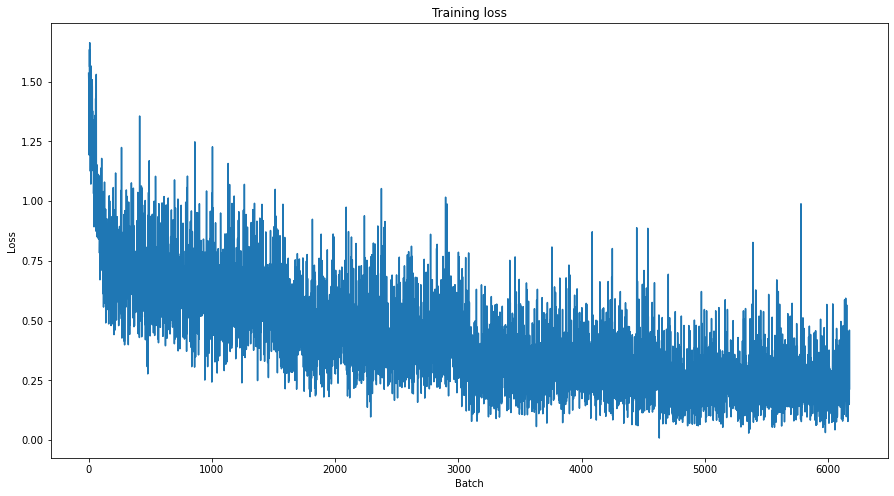

In [9]:

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
      
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [10]:
text_bert = list(data['text'])#-------------------->List of sentences
senti_bert = list(data['sentiment'])#-------------->List of Labels
senti_dict = {'neu':0,'p':1,'vp':2,'n':3,'vn':4}#-->Dictionary to convert labels to integers
f = lambda st:senti_dict[st]#---------------------->Function to assign label to the integer
senti_bert = [f(t) for t in senti_bert]#----------->Converting labels to integers


# load test data
sentences = ["[CLS] " + query + " [SEP]" for query in text_bert]
labels = senti_bert

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 89.45%


In [31]:
for batch in prediction_dataloader:
    print(len(batch[0]))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
3

In [12]:
predictions[0]

array([[ 6.0109    , -1.0597469 , -1.8625293 , -2.4695568 , -2.531415  ],
       [-3.0282161 , -1.6760277 , -2.8238711 ,  4.7309623 ,  3.0119448 ],
       [-3.3736143 , -2.3187437 , -2.3784947 ,  4.3441076 ,  3.791072  ],
       [-1.6751084 , -2.678672  , -3.504452  ,  4.7692933 ,  3.3433354 ],
       [-1.6367537 , -1.3715299 , -3.16671   ,  4.612809  ,  2.809559  ],
       [ 5.629954  ,  1.2431861 , -3.000126  , -1.3866882 , -3.8046763 ],
       [-2.8872514 ,  5.4930115 ,  2.06887   , -0.85452956, -2.5973027 ],
       [ 5.8155847 , -2.6221688 , -1.7526546 , -2.1228518 , -0.6754852 ],
       [ 5.634776  , -2.0713327 , -1.3379409 , -2.5844479 , -1.6194586 ],
       [-2.7284822 ,  5.062082  ,  3.0661364 , -2.1898077 , -2.6654265 ],
       [ 5.5970736 ,  0.81000865, -2.6330378 , -1.353641  , -3.5552058 ],
       [-3.286189  ,  4.0752583 ,  3.9515939 , -2.406211  , -2.0069392 ],
       [-1.7887404 , -2.6386926 , -3.3840487 ,  4.8435225 ,  3.2954342 ],
       [-2.5234625 , -1.3825445 , -3.0

### Peparing the Embedding Matrix

In [ ]:
def int_to_word(word_index,i):
    index_word_items=word_index.items()
    j=[item for item in index_word_items if item[1]==i]
    return j[0][0]

def get_emb_mat(data,l_input_vec):
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(data['text'].values)
    word_index = tokenizer.word_index#---------------------------------------->Needed for embedding matrix
    sentences = [word_tokenize(text) for text in list(data['text'])]
    #Get a list of tokenized sentences
    w2vmodel = Word2Vec(sentences, min_count=1, size=l_input_vec)#------------->Needs tokenized sentences
    vocab = w2vmodel.wv.vocab.keys()
    vocab_dict = w2vmodel.wv.vocab
    wordsInVocab = len(vocab)

    nb_words = len(word_index)+1

    embedding_matrix = np.zeros((nb_words, l_input_vec))#----------------------->Needs word_index and Word2Vec model
    for word, i in word_index.items():
        if word in vocab:
            embedding_matrix[i] = w2vmodel.wv.word_vec(word)
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix,vocab_dict,w2vmodel

def train_nn(model,X_train,Y_train,batch_size,epochs):
    #batch_size = 34
    #batch_size = 20
    model.fit(X_train, Y_train, epochs = 12, batch_size=batch_size, verbose = 2)
    return model


def get_emb_word_vectors(word_index,model,l_input_vec,i):
    try:
        word = int_to_word(word_index,i)
        vec = model[word]
        return vec
    except:
        return [0 for i in range(l_input_vec)]

#w2vmodel = get_emb_mat(data,100)[2]
#get_emb_word_vectors(word_index,w2vmodel,100,1)

def get_emb_sentence_vectors(word_index,model,l_input_vec,X):
    g = lambda l:[get_emb_word_vectors(word_index,model,l_input_vec,i) for i in l]
    X_emb = [g(k) for k in X]
    return X_emb

## Parameters

In [ ]:
l_input_vec = 100
lstm_out = 196
batch_size = 20
epochs = 12
spatial_drp = 0.4
drp = 0.2
rec_drp = 0.2
dense_out = np.shape(Y)[1]

In [ ]:
X.shape[1]

### Declaring the LSTM Model and training it.

In [ ]:
embedding_matrix = get_emb_mat(data,l_input_vec)[0]
embed_dim = l_input_vec


In [ ]:
embedding_matrix[1]

In [ ]:
model = Sequential()
model.add(Embedding(len(embedding_matrix), embed_dim ,weights=[embedding_matrix],input_length = 34,trainable=False))
model.add(SpatialDropout1D(spatial_drp))
model.add(LSTM(lstm_out, dropout=drp, recurrent_dropout=rec_drp))
model.add(Dense(dense_out,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
train_nn(model,X_train,Y_train,batch_size,epochs)

In [ ]:
    
def sortSecond(val): 
    return val[1] 

def get_ngrams(doc,n):
    tokens = doc.split()
    all_ngrams = ngrams(tokens, n)
    return all_ngrams

def get_everygrams(doc):
    tokens = doc.split()
    every_grams = list(everygrams(tokens))
    every_grams = [' '.join(k) for k in every_grams]
    return every_grams


def lstm_sent(text,sent):
    twt = [text]
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=34, dtype='int32', value=0)
    #print(twt)
    sentiment_n = model.predict(twt,batch_size=1,verbose = 2)
    #sentiment = translate(flatten(list(sentiment_n[0])))
    sentiment = translate(list(sentiment_n[0]),sent)
    return sentiment,sentiment_n

    
def vader_sent(sentence,a):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= a :
        return "positive" 
    elif sentiment_dict['compound'] <= a*(-1) :
        return "negative"
    else :
        return "neutral"
    
def vader_sent_num(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    sent_num = sentiment_dict['compound']
    return sent_num

def get_sig_ngram(sentence,sentiment,perc):
    n = int(math.ceil(len(sentence.split())*perc))
    g = lambda sentiment:max if sentiment =='positive' else min
    #sentence = custom_spell(str(sentence))
    ngrams = get_ngrams(sentence,n)
    sent_dict = [(' '.join(k),vader_sent_num(' '.join(k))) for k in ngrams]
    prominent_sent = g(sentiment)([v[1] for v in sent_dict])
    prom_ngrams = [ntup for ntup in sent_dict if ntup[1]==prominent_sent]
    return prom_ngrams[0][0]

def get_sig_ngram_inv(sentence,sentiment,perc):
    n = int(math.ceil(len(sentence.split())*perc))
    g = lambda sentiment:max if sentiment =='positive' else min
    #sentence = custom_spell(str(sentence))
    ngrams = get_ngrams(sentence,n)
    sent_dict = [(' '.join(k),vader_sent_num(' '.join(k))) for k in ngrams]
    prominent_sent = g(sentiment)([v[1] for v in sent_dict])
    prom_ngrams = [ntup for ntup in sent_dict if ntup[1]==prominent_sent]
    return sent_dict



def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))




In [ ]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [ ]:
#These functions translate the ratings from vectors to the original categories
def flatten(l):
    m = max(l)
    g = lambda i,m: 1 if i>=m else 0
    l = list(map(g,l,[m]*len(l)))
    return l
def translate(l,sent):
    s_categories = ['n','neu','p','vn','vp']
    g = lambda l: l[s_categories.index(sent)]
    #sentiment = s_categories[g(l)]
    sentiment = g(l)
    return sentiment

def get_jaccard(df,rows):
    
    df1=df.sample(rows)
    #print(df1)
    g = lambda senti:'vp' if senti=='positive' else 'vn'
    df1['algo_text'] = df1.apply(lambda row:str(row['text']) if row['sentiment']=='neutral' else get_f_text(str(row['text']),g(row['sentiment'])),axis=1)
    df1['jaccard'] = df1.apply(lambda row:jaccard(str(row['selected_text']),str(row['algo_text'])),axis=1)
    score = np.average(list(df1['jaccard']))
    return score,df1
def get_jaccard_thresh(df,rows,perc,thresh):
    df1=df.sample(rows)
    
    df1['algo_text'] = df1.apply(lambda row:row['text'] if row['sentiment']=='neutral' else get_sig_ngram(row['text'],row['sentiment'],perc),axis=1)
    df1['jaccard'] = df1.apply(lambda row:jaccard(str(row['selected_text']),str(row['algo_text'])),axis=1)
    score = np.average(list(df1['jaccard']))
    df2 = df1[df1['jaccard']<thresh] 
    return score,df2

def get_sel_text(text,sent):
    f = lambda x: re.sub('[^a-zA-z0-9\s]',' ',x)
    #g = lambda x: str(x).lower()
    #text = g(text)
    text = f(text)
    e = get_everygrams(text)
    lis = [(i,lstm_sent(i,sent)[0]) for i in e]
    #lis = [i for i in lis if i[1]==sent]
    return lis

def get_f_text(text,sent):
    t_list = get_sel_text(text,sent)
    m = max([t[1] for t in t_list])
    f = [t for t in t_list if t[1]>=m]
    return f[0][0]
    

In [ ]:
score,df1 = get_jaccard(df_train,1000)

In [ ]:
score

In [ ]:
df1 = df1[df1['sentiment']!='neutral']

In [ ]:
df1.sort_values('jaccard').tail(30)